In [3]:
!nvidia-smi

Sun Jan 28 00:56:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

##**Data Gathering and Preprocessing**

In [6]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git

Cloning into 'WasteClassificationNeuralNetwork'...
remote: Enumerating objects: 5092, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5092 (delta 10), reused 23 (delta 9), pack-reused 5068
Receiving objects: 100% (5092/5092), 223.89 MiB | 32.75 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (5082/5082), done.


In [7]:
#LOAD DATA
DIR = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


##**Model Training**

In [8]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

12683000/12683000 [==============================] - 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 34s 566ms/step - loss: 243.2698 - accuracy: 0.5771 - val_loss: 101.7284 - val_accuracy: 0.7692
Epoch 2/50
36/36 [==============================] - 20s 478ms/step - loss: 45.1742 - accuracy: 0.7830 - val_loss: 11.2145 - val_accuracy: 0.6430
Epoch 3/50
36/36 [==============================] - 18s 446ms/step - loss: 6.4642 - accuracy: 0.5607 - val_loss: 4.3981 - val_accuracy: 0.5187
Epoch 4/50
36/36 [==============================] - 18s 445ms/step - loss: 4.1657 - accuracy: 0.5323 - val_loss: 3.9862 - val_accuracy: 0.5207
Epoch 5/50
36/36 [==============================] - 18s 422ms/step - loss: 4.0140 - accuracy: 0.5275 - val_loss: 3.8980 - val_accuracy: 0.5345
Epoch 6/50
36/36 [==============================] - 18s 391ms/step - loss: 3.9537 - accuracy: 0.5395 - val_loss: 3.8223 - val_accuracy: 0.5148
Epoch 7/50
36/36 [==============================] - 17s 393ms/step - loss: 3.8873 - accuracy: 0.5456 - val_loss: 3.7821 - val_accuracy: 0.5168
Epoc

In [23]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 39.2 MB/s eta 0:00:00


In [10]:
model.save("/content/model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 128, 128, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 128, 128, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

##**Model Evaluation**

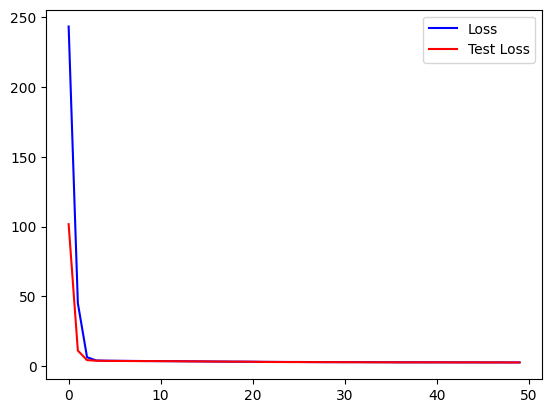

In [11]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

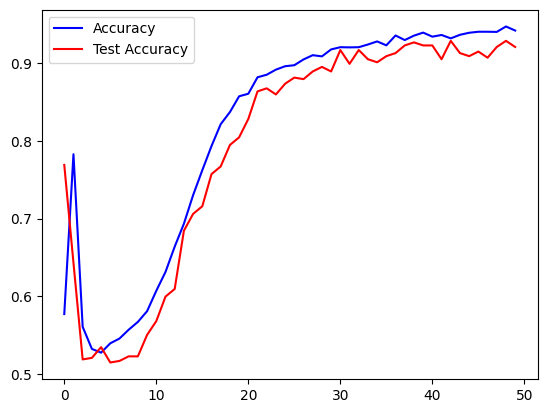

In [12]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

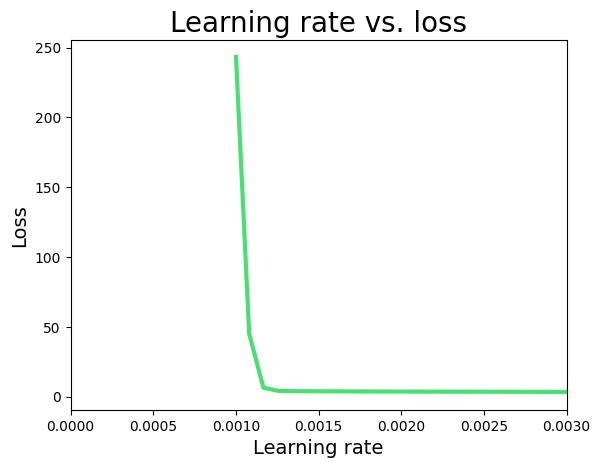

In [13]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 [==============================] - 0s 73ms/step
[ 7.8262143  4.5425234 10.2569065  4.4548616  8.053958  37.520565
  3.679157   6.108202  17.557623 ] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Paper and Cardboard 37.52056658267975%


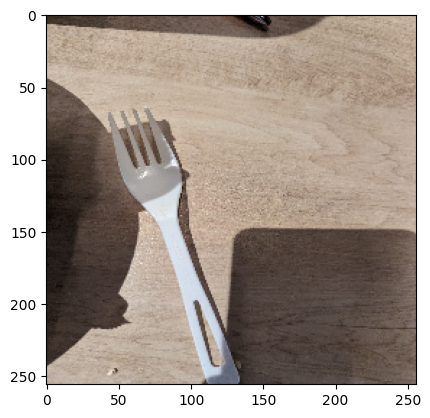

In [22]:
import requests

#img_data = requests.get("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.greencompostables.com%2Fwp-content%2Fuploads%2F2020%2F02%2F20200113_154636.jpg&f=1&nofb=1&ipt=3a278e69615ecbb2f9a2dcd67cc05fc2e350204b43aed4fadad771b0a130a16e&ipo=images").content
#with open('img.jpg', 'wb') as handler:
 #   handler.write(img_data)

path = "/content/PXL_20240128_012959388.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 45ms/step


<Figure size 1000x1000 with 0 Axes>

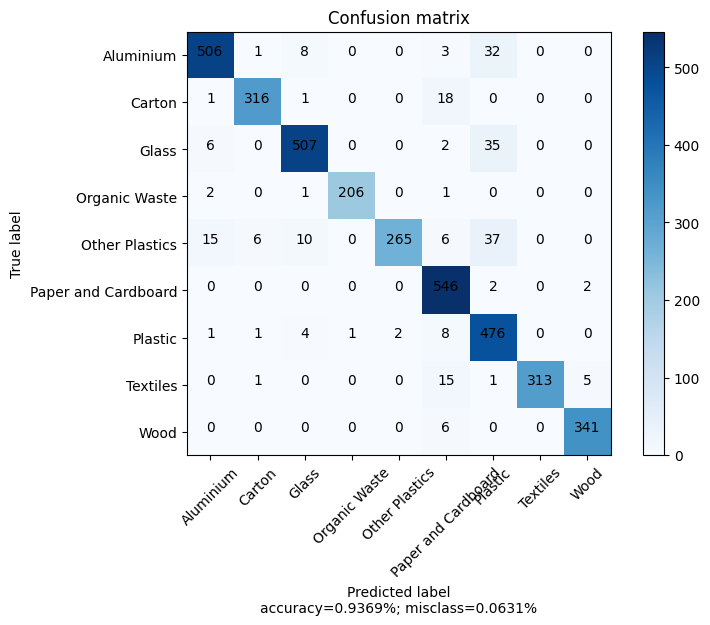

In [17]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

**Advanced Filter Visualization**

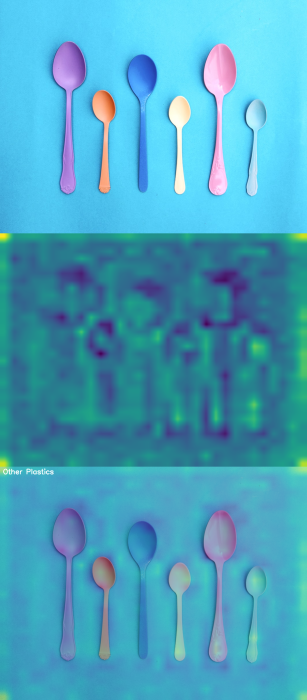

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/img.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)

In [24]:
# converting to tensorflowjs model
!tensorflowjs_converter --input_format keras \
                       /content/model.h5 \
                       /content/tfjs_target_dir

2024-01-28 02:14:00.594516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 02:14:00.594587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 02:14:00.596500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 02:14:03.810535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
# zipping folder
!zip -r /content/model.zip /content/tfjs_target_dir

Streaming output truncated to the last 5000 lines.
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/Aluminium/alum (10).jpg (deflated 4%)
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/Aluminium/metal310.jpg (deflated 1%)
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/Aluminium/metal260.jpg (deflated 3%)
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/Aluminium/metal11.jpg (deflated 1%)
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/Aluminium/metal344.jpg (deflated 2%)
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/Aluminium/metal355.jpg (deflated 4%)
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/Aluminium/alum (189).jpg (deflated 0%)
  adding: content/tfjs_target_dir/WasteClassificationNeuralNetwork/WasteImagesDataset/

In [28]:
#download the files
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>